# Wildfire Risk - Explore & Bias Report
__Team 3 - Dave Friesen, John Chen, and Kyle Dalope__<br>
__ADS-508-02-SP23__<br><br>
__GitHub link: https://github.com/davefriesen/wildfire-risk__

In [30]:
__authors__ = ['Dave Friesen', 'John Chen', 'Kyle Dalope']
__contact__ = ['dfriesen@sandiego.edu', 'johnchen@sandiego.edu', 'kdalope@sandiego.edu']
__date__ = '2023-03-20'
__license__ = 'MIT'
__version__ = '1.0.1'

# Setup Basics

In [31]:
#Install
!pip install -q smclarify==0.1
!pip install --disable-pip-version-check -q PyAthena==2.1.0

# Import basic libraries
import boto3
import sagemaker

# Import data access libraries
from pyathena import connect
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker

In [32]:
# Establish session fundamentals
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
#account_id = boto3.Session().client(service_name='sagemaker', region_name=region)

In [33]:
%store

Stored variables and their in-db values:
auto_ml_job_name                                      -> 'automl-dm-30-03-35-20'
autopilot_endpoint_arn                                -> 'arn:aws:sagemaker:us-east-1:857283526476:endpoint
autopilot_endpoint_wf                                 -> 'automl-dm-ep-30-04-47-49'
autopilot_model_arn_wf                                -> 'arn:aws:sagemaker:us-east-1:857283526476:model/au
autopilot_model_wf                                    -> 'automl-dm-model-30-04-47-47'
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-857283526476/data/amazon
autopilot_train_s3_wf                                 -> 's3://sagemaker-us-east-1-857283526476/data/wildfi
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-857283526476/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-857283526476/bias-detect
bias_data_s3_uri                                      -> 's

# Get Data from S3

In [34]:
import pandas as pd

data = pd.read_csv("../data/merged.csv", low_memory=False)
data.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CDSD_ATTRIBUTES,CLDD,CLDD_ATTRIBUTES,DT00,...,InitialLatitude,InitialLongitude,IsFireCauseInvestigated,IsTrespass,POOCity,POOState,PredominantFuelModel,PrimaryFuelModel,ym_date,fire
0,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,USR0000CABS,40.3983,-122.8333,579.1,"ARBUCKLE BASIN CALIFORNIA, CA US",0.0,NaN,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [35]:
data.info() #See columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42289 entries, 0 to 42288
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STATION                   42289 non-null  object 
 1   LATITUDE                  42289 non-null  float64
 2   LONGITUDE                 42289 non-null  float64
 3   ELEVATION                 42289 non-null  float64
 4   NAME                      42289 non-null  object 
 5   CDSD                      39981 non-null  float64
 6   CDSD_ATTRIBUTES           39577 non-null  object 
 7   CLDD                      42241 non-null  float64
 8   CLDD_ATTRIBUTES           42241 non-null  object 
 9   DT00                      42279 non-null  float64
 10  DT00_ATTRIBUTES           42279 non-null  object 
 11  DT32                      42279 non-null  float64
 12  DT32_ATTRIBUTES           42279 non-null  object 
 13  DX32                      42270 non-null  float64
 14  DX32_A

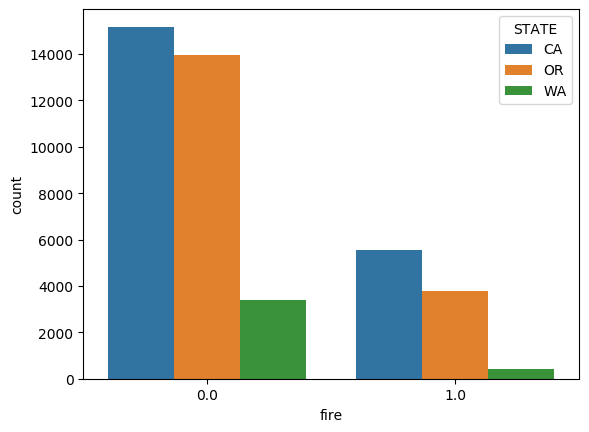

In [37]:
import seaborn as sns
sns.countplot(data=data, x="fire", hue="STATE")
plt.show()

#sns.boxplot(x = "fire", y = "geohash", data = data)
#plt.show()

# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [38]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


# Writing DataConfig
A DataConfig object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (label), the header names, and the dataset type.

In [39]:
bias_report_output_path = "s3://{}/data".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path='../data/merged.csv',
    s3_output_path=bias_report_output_path,
    label="fire",
    headers=data.columns.to_list(),
    dataset_type="text/csv",
)

## Writing BiasConfig and Defining 
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is `fire==0`, `STATE` is the sensitive column, and `CA` is the sensitive value.
* desirable outcome = fire [1] or no fire [0]
* sensitive column = STATE
* sensitive value = CA

label_column = LabelColumn('target', df['target'], [1])

In [40]:
#Measure bias for geohash attribute
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="STATE",
    facet_values_or_threshold=["CA"],                           
)

## Detect Bias with a SageMaker Processing Job and Clarify

In [41]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'CDSD', 'CDSD_ATTRIBUTES', 'CLDD', 'CLDD_ATTRIBUTES', 'DT00', 'DT00_ATTRIBUTES', 'DT32', 'DT32_ATTRIBUTES', 'DX32', 'DX32_ATTRIBUTES', 'DX70', 'DX70_ATTRIBUTES', 'DX90', 'DX90_ATTRIBUTES', 'EMNT', 'EMNT_ATTRIBUTES', 'EMXT', 'EMXT_ATTRIBUTES', 'HDSD', 'HDSD_ATTRIBUTES', 'HTDD', 'HTDD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'geohash', 'year', 'month', 'PLT_CN', 'COND_STATUS_CD', 'MAPDEN', 'STDAGE', 'STDSZCD', 'FLDSZCD', 'SITECLCD', 'SICOND', 'STDORGCD', 'SLOPE', 'PHYSCLCD', 'GSSTKCD', 'DSTRBCD1', 'TRTCD1', 'PRESNFCD', 'FLDAGE', 'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG', 'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG', 'STATE', 'WATERCD', 'LAT', 'LON', 'ContainmentDateTime', 'ControlDateTime', 'DiscoveryAcres', 'EstimatedCostToDate', 'FinalAcres', 'FireBehaviorGene

In [42]:
run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

'Clarify-Pretraining-Bias-2023-04-03-04-44-28-469'

In [43]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [44]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [45]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [46]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/Clarify-Pretraining-Bias-2023-04-03-04-44-28-469/input/dataset/merged.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/data/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-857283526476/data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2023-04-03-04-44-28-469', 

In [47]:
running_processor.wait(logs=False)

....................................................................!

# Download Report From S3
The class-imbalance metric should match the value calculated for the unbalanced dataset using the open source version above.

In [48]:
!aws s3 ls $bias_report_output_path/

2023-03-24 18:49:50   13673831 amazon_reviews_us_Digital_Software_v1_00_autopilot.csv
2023-04-03 04:50:10       1949 analysis.json
2023-04-03 04:44:29       1625 analysis_config.json
2023-04-03 04:50:10     524380 report.html
2023-04-03 04:50:10     253339 report.ipynb
2023-04-03 04:50:10     268461 report.pdf
2023-03-30 03:34:37    1045513 wildfire_risk_autopilot.csv


In [49]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://sagemaker-us-east-1-857283526476/data/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-857283526476/data/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-857283526476/data/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-857283526476/data/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-857283526476/data/report.html to generated_bias_report/report.html
download: s3://sagemaker-us-east-1-857283526476/data/wildfire_risk_autopilot.csv to generated_bias_report/wildfire_risk_autopilot.csv
download: s3://sagemaker-us-east-1-857283526476/data/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv to generated_bias_report/amazon_reviews_us_Digital_Software_v1_00_autopilot.csv


In [50]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

# Balance the Dataset

In [51]:
print("Shape of dataframe before splitting {}".format(data.shape))

Shape of dataframe before splitting (42289, 89)


In [52]:
# Balance the dataset down to the minority class
df_grouped_by = data.groupby(["fire"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (19460, 89)


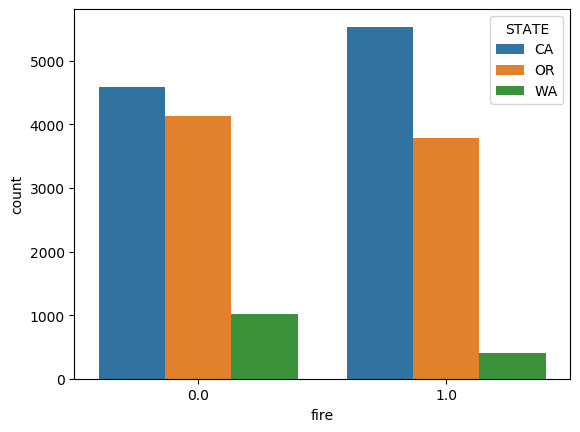

In [53]:
sns.countplot(data=df_balanced, x="fire", hue="STATE")
plt.show()

In [54]:
#Drop extra/duplicate columns 
df_balanced_reduced = df_balanced.drop(columns=[
    'ContainmentDateTime',
    'ControlDateTime',
    'DiscoveryAcres',
    'EstimatedCostToDate',
    'FinalAcres',
    'FireCause',
    'FireBehaviorGeneral',
    'FireBehaviorGeneral1',
    'FireBehaviorGeneral2',
    'FireBehaviorGeneral3',
    'FireCauseGeneral',
    'FireCauseSpecific',
    'FireDiscoveryDateTime',
    'FireOutDateTime',
    'GACC',
    'IncidentName',
    'IncidentShortDescription',
    'InitialLatitude',
    'InitialLongitude',
    'IsFireCauseInvestigated',
    'IsTrespass',
    'POOCity',
    'POOState',
    'PredominantFuelModel',
    'PrimaryFuelModel',
    'ym_date'    
])

# Split the Data into Train, Validation, and Test Sets

In [55]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced_reduced, test_size=0.10, stratify=df_balanced_reduced["fire"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["fire"])

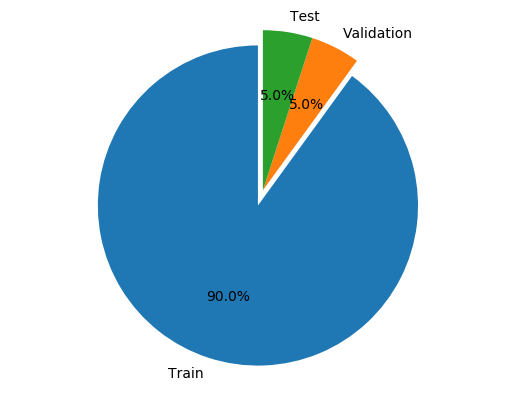

In [56]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train, 5% Validation, and 5% Test Data Split

In [57]:
df_train.shape

(17514, 63)

In [58]:
df_validation.shape

(973, 63)

In [59]:
df_test.shape

(973, 63)

In [60]:
#df_train = df_train[["fire", "ContainmentDateTime", "ControlDateTime", "DiscoveryAcres", "FireCause", "FireDiscoveryDateTime", "FireOutDateTime", "POOState", "InitialLatitude", "InitialLongitude", "GACC"]]
#df_train.shape

KeyError: "['ContainmentDateTime', 'ControlDateTime', 'DiscoveryAcres', 'FireCause', 'FireDiscoveryDateTime', 'FireOutDateTime', 'POOState', 'InitialLatitude', 'InitialLongitude', 'GACC'] not in index"

In [61]:
df_train.head(5)

,STATION,LATITUDE,LONGITUDE,ELEVATION,NAME,CDSD,CDSD_ATTRIBUTES,CLDD,CLDD_ATTRIBUTES,DT00,...,CARBON_LITTER,CARBON_SOIL_ORG,CARBON_STANDING_DEAD,CARBON_UNDERSTORY_AG,CARBON_UNDERSTORY_BG,STATE,WATERCD,LAT,LON,fire
2257,USR0000CWWO,37.8511,-119.6500,2446.0,"WHITE WOLF CALIFORNIA, CA US",0.0,U,0.0,",U",0.0,...,21.578701,22.216451,10.25461,0.453267,0.050363,CA,0.0,37.750869,-119.519830,0.0
5106,USR0000OOWY,43.5833,-117.2333,1341.1,"OWYHEE RIDGE OREGON, OR US",346.8,U,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,OR,NaN,43.658674,-117.175609,0.0
6503,USR0000WABE,46.3500,-123.1000,883.9,"ABERNATHY MOUNTAIN WASHINGTON, WA US",0.0,U,0.0,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,WA,0.0,46.431084,-123.166813,0.0
4600,USR0000CPOT,32.6058,-116.6089,714.8,"POTRERO CALIFORNIA, CA US",596.5,U,33.3,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,CA,NaN,32.666760,-116.595950,0.0
16006,USR0000CSFD,34.1208,-117.9458,152.4,"SANTA FE DAM CALIFORNIA, CA US",533.9,U,295.4,",U",0.0,...,NaN,NaN,NaN,NaN,NaN,CA,NaN,34.079497,-117.992602,1.0


In [62]:
#Write a Train csv with Header for Autopilot
autopilot_train_path = "./wildfire_risk_autopilot.csv"
df_train.to_csv(autopilot_train_path, index=False, header=True)

In [63]:
train_s3_prefix = "data"
autopilot_train_s3_wf = sess.upload_data(path=autopilot_train_path, key_prefix=train_s3_prefix)
autopilot_train_s3_wf

's3://sagemaker-us-east-1-857283526476/data/wildfire_risk_autopilot.csv'

In [64]:
!aws s3 ls $autopilot_train_s3_wf

2023-04-03 05:22:26    6237001 wildfire_risk_autopilot.csv


# Store Variables and Close Session

In [65]:
# Store variables for subsequent notebooks
%store autopilot_train_s3_wf

%store

Stored 'autopilot_train_s3_wf' (str)
Stored variables and their in-db values:
auto_ml_job_name                                      -> 'automl-dm-30-03-35-20'
autopilot_endpoint_arn                                -> 'arn:aws:sagemaker:us-east-1:857283526476:endpoint
autopilot_endpoint_wf                                 -> 'automl-dm-ep-30-04-47-49'
autopilot_model_arn_wf                                -> 'arn:aws:sagemaker:us-east-1:857283526476:model/au
autopilot_model_wf                                    -> 'automl-dm-model-30-04-47-47'
autopilot_train_s3_uri                                -> 's3://sagemaker-us-east-1-857283526476/data/amazon
autopilot_train_s3_wf                                 -> 's3://sagemaker-us-east-1-857283526476/data/wildfi
balanced_bias_data_jsonlines_s3_uri                   -> 's3://sagemaker-us-east-1-857283526476/bias-detect
balanced_bias_data_s3_uri                             -> 's3://sagemaker-us-east-1-857283526476/bias-detect
bias_data_s3_uri      

In [66]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [67]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>